In [166]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import pandas as pd
import geopandas as gpd
import shapely
import nomad.io.base as loader
import numpy as np
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import geopandas as gpd
import nomad.visit_attribution as va
import nomad.filters as filters
from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, compute_precision_recall_f1
import matplotlib.pyplot as plt

In [ ]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
poi_table = gpd.read_file('../garden_city.gpkg')

diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", traj_cols=traj_cols,
                       parse_dates=True)
sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", traj_cols=traj_cols,
                      parse_dates=True)

sparse_df.loc[:,'x'] = sparse_df['x'] - 2*(4265699)
sparse_df.loc[:,'y'] = sparse_df['y'] + 2*(4392976)

diaries_df.loc[:,'x'] = diaries_df['x'] - 2*(4265699)
diaries_df.loc[:,'y'] = diaries_df['y'] + 2*(4392976)

In [129]:
diaries_df

,timestamp,longitude,latitude,x,y,date,local_timestamp,duration,location,uid
0,1704081660,38.321380,-36.667407,4265916.5,-4392848.5,2024-01-01,2024-01-01 06:01:00+02:00,120,h-x13-y8,admiring_curie
1,1704088860,NaN,NaN,NaN,NaN,2024-01-01,2024-01-01 08:01:00+02:00,5,None,admiring_curie
2,1704089160,38.319696,-36.666921,4265729.0,-4392781.0,2024-01-01,2024-01-01 08:06:00+02:00,10,r-x3-y12,admiring_curie
3,1704089760,NaN,NaN,NaN,NaN,2024-01-01,2024-01-01 08:16:00+02:00,2,None,admiring_curie
4,1704089880,38.319696,-36.667083,4265729.0,-4392803.5,2024-01-01,2024-01-01 08:18:00+02:00,28,r-x3-y11,admiring_curie
...,...,...,...,...,...,...,...,...,...,...
66765,1705666020,38.321110,-36.667840,4265886.5,-4392908.5,2024-01-19,2024-01-19 14:07:00+02:00,234,w-x12-y3,zealous_ramanujan
66766,1705680060,NaN,NaN,NaN,NaN,2024-01-19,2024-01-19 18:01:00+02:00,5,None,zealous_ramanujan
66767,1705680360,38.320976,-36.666759,4265871.5,-4392758.5,2024-01-19,2024-01-19 18:06:00+02:00,835,h-x11-y13,zealous_ramanujan
66768,1705730460,NaN,NaN,NaN,NaN,2024-01-20,2024-01-20 08:01:00+02:00,5,None,zealous_ramanujan


In [130]:
sparse_df

,uid,timestamp,longitude,latitude,x,y,local_timestamp,ha,date
0,inspiring_beaver,1704093480,38.320071,-36.666358,4.265771e+06,-4.392703e+06,2024-01-01 09:18:00+02:00,11.25,2024-01-01
1,inspiring_beaver,1704093720,38.319979,-36.666396,4.265761e+06,-4.392708e+06,2024-01-01 09:22:00+02:00,11.25,2024-01-01
2,inspiring_beaver,1704095220,38.320034,-36.666405,4.265767e+06,-4.392709e+06,2024-01-01 09:47:00+02:00,11.25,2024-01-01
3,inspiring_beaver,1704097140,38.320061,-36.666418,4.265770e+06,-4.392711e+06,2024-01-01 10:19:00+02:00,11.25,2024-01-01
4,inspiring_beaver,1704097440,38.320072,-36.666500,4.265771e+06,-4.392723e+06,2024-01-01 10:24:00+02:00,11.25,2024-01-01
...,...,...,...,...,...,...,...,...,...
143763,heuristic_lamport,1705739520,38.321248,-36.667898,4.265902e+06,-4.392917e+06,2024-01-20 10:32:00+02:00,11.25,2024-01-20
143764,heuristic_lamport,1705740180,38.321040,-36.667721,4.265879e+06,-4.392892e+06,2024-01-20 10:43:00+02:00,11.25,2024-01-20
143765,heuristic_lamport,1705740780,38.321128,-36.667888,4.265888e+06,-4.392915e+06,2024-01-20 10:53:00+02:00,11.25,2024-01-20
143766,heuristic_lamport,1705741920,38.321133,-36.667800,4.265889e+06,-4.392903e+06,2024-01-20 11:12:00+02:00,11.25,2024-01-20


In [131]:
poi_table

,building_id,type,geometry
0,p-x13-y11,park,"POLYGON ((-4265504 4393111, -4265504 4393171, ..."
1,h-x8-y8,home,"POLYGON ((-4265579 4393081, -4265579 4393111, ..."
2,h-x9-y8,home,"POLYGON ((-4265549 4393081, -4265549 4393096, ..."
3,h-x10-y8,home,"POLYGON ((-4265534 4393081, -4265534 4393096, ..."
4,h-x11-y8,home,"POLYGON ((-4265519 4393081, -4265519 4393096, ..."
...,...,...,...
101,r-x3-y7,retail,"POLYGON ((-4265654 4393081, -4265654 4393096, ..."
102,r-x0-y5,retail,"POLYGON ((-4265669 4393036, -4265669 4393081, ..."
103,r-x3-y6,retail,"POLYGON ((-4265654 4393066, -4265654 4393081, ..."
104,r-x3-y5,retail,"POLYGON ((-4265654 4393051, -4265654 4393066, ..."


In [135]:
# Select data from 1 user
user1 = diaries_df.uid.unique()[0]
sparse1 = sparse_df.loc[sparse_df['uid'] == user1]
diary1 = diaries_df.loc[diaries_df.uid == user1]

In [136]:
completeness_df = filters.q_stats(sparse_df, traj_cols=traj_cols)

In [137]:
completeness_df.q_stat.quantile([0.5, 0.7, 0.85])

0.50    0.381897
0.70    0.490051
0.85    0.578152
Name: q_stat, dtype: float64

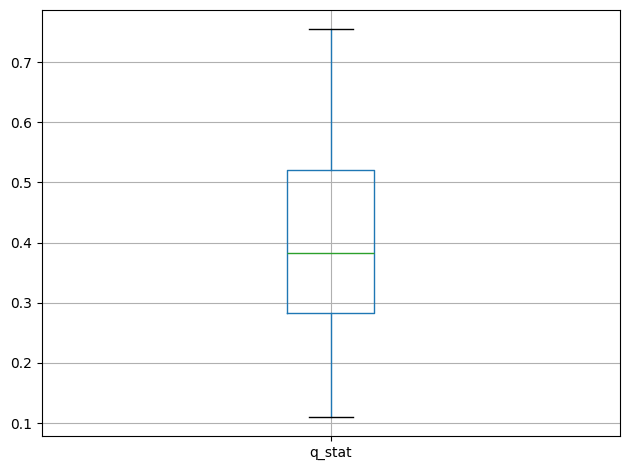

In [138]:
plt.figure()
completeness_df.boxplot(column="q_stat")
plt.grid(True)
plt.tight_layout()

plt.show()

In [151]:
%time
DUR_MIN=5
DT_MAX=90
DELTA_ROAM=30

stop_table_lachesis = LACHESIS.lachesis(traj=sparse1,
                                        dur_min=DUR_MIN,
                                        dt_max=DT_MAX,
                                        delta_roam=DELTA_ROAM,
                                        traj_cols=traj_cols,
                                        keep_col_names=True,
                                        complete_output=True)

labels_lachesis = LACHESIS._lachesis_labels(traj=sparse1,
                                            dur_min=DUR_MIN,
                                            dt_max=DT_MAX,
                                            delta_roam=DELTA_ROAM,
                                            traj_cols=traj_cols)
labels_lachesis.name = 'cluster'

pred_lachesis = va.point_in_polygon(traj=sparse1,
                 labels=labels_lachesis,
                 stop_table=stop_table_lachesis,
                 poi_table=poi_table,
                 traj_cols=traj_cols,
                 is_datetime=False,
                 is_long_lat=False)

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 13.1 μs


/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'user_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


In [153]:
%time

TIME_THRESH=90

stop_table_hdbscan = HDBSCAN.st_hdbscan(
                traj=sparse1,
                traj_cols=traj_cols,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=3)

labels_hdbscan = HDBSCAN.hdbscan_labels(
                traj=sparse1,
                traj_cols=traj_cols,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=3)

labels_hdbscan.name = 'cluster'

pred_hdbscan = va.point_in_polygon(traj=sparse1,
                 labels=labels_hdbscan,
                 stop_table=stop_table_hdbscan,
                 poi_table=poi_table,
                 traj_cols=traj_cols,
                 is_datetime=False,
                 is_long_lat=False)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 μs


/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'user_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


In [167]:
traj_cols = {'uid':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
stop_detection_algos = ['lachesis', 'ta-dbscan', 'hdbscan']
metrics_df = pd.DataFrame()
TIME_THRESH=240
DIST_THRESH=20
MIN_PTS=2

DUR_MIN=5
DT_MAX=240
DELTA_ROAM=30

for user in diaries_df.uid.unique()[:5]:
    sparse = sparse_df[sparse_df['uid'] == user]
    truth = diaries_df.loc[diaries_df['uid'] == user]

    for algo in stop_detection_algos:
        if algo == 'lachesis':
            stop_table = LACHESIS.lachesis(
                traj=sparse,
                dur_min=DUR_MIN,
                dt_max=DT_MAX,
                delta_roam=DELTA_ROAM,
                traj_cols=traj_cols
            )
            labels = LACHESIS._lachesis_labels(
                traj=sparse,
                dur_min=DUR_MIN,
                dt_max=DT_MAX,
                delta_roam=DELTA_ROAM,
                traj_cols=traj_cols
            )
            labels.name = 'cluster'
        elif algo == 'ta-dbscan':
            labels, stop_table = TADBSCAN.temporal_dbscan(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols
            )
            # labels = TADBSCAN._temporal_dbscan_labels(
            #     data=sparse,
            #     time_thresh=TIME_THRESH,
            #     dist_thresh=DIST_THRESH,
            #     min_pts=MIN_PTS,
            #     traj_cols=traj_cols
            # )
            labels.name = 'cluster'
        else:  # 'hdbscan'
            labels, stop_table = HDBSCAN.st_hdbscan(
                traj=sparse,
                traj_cols=traj_cols,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=3
            )
            # labels = HDBSCAN.hdbscan_labels(
            #     traj=sparse,
            #     traj_cols=traj_cols,
            #     time_thresh=TIME_THRESH,
            #     min_pts=2,
            #     min_cluster_size=3
            # )
            labels.name = 'cluster'
        
        pred = va.point_in_polygon(traj=sparse,
                 labels=labels,
                 stop_table=stop_table,
                 poi_table=poi_table,
                 traj_cols=traj_cols,
                 is_datetime=False,
                 is_long_lat=False)
        
        # Step 1: Compute overlaps
        overlaps = overlapping_visits(left=pred,
                                      right=truth,
                                      match_location=False)

        # Step 2: Compute visitation errors (missed, merged, split)
        errors = compute_visitation_errors(overlaps=overlaps,
                                           true_visits=truth)

        # Step 3: Compute precision, recall, and F1
        prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                           pred_visits=pred,
                                           true_visits=truth)

        all_metrics = {**errors, **prf1, 'user': user, 'algorithm': algo}
        metrics_df = pd.concat([metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'uid' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'uid' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory co

In [168]:
metrics_df.groupby(['algorithm'])[['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']].mean()

,missed_fraction,merged_fraction,split_fraction,precision,recall,f1
algorithm,,,,,,
hdbscan,0.744319,0.238266,0.007106,0.968431,0.424618,0.556808
lachesis,0.833695,0.019392,0.056763,0.997026,0.292078,0.434731
ta-dbscan,0.841011,0.031284,0.004246,0.994529,0.311313,0.455403


<Figure size 640x480 with 0 Axes>

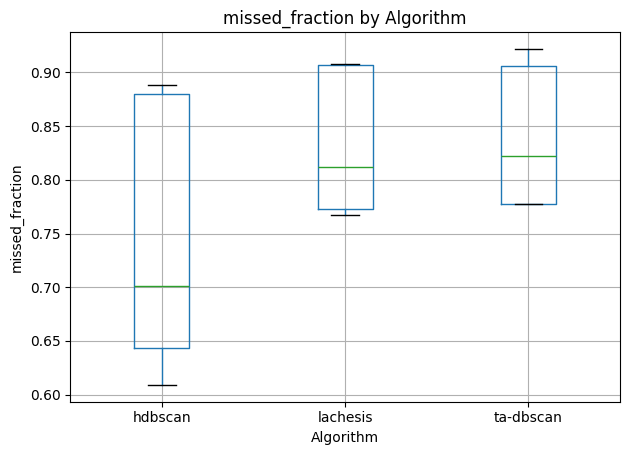

<Figure size 640x480 with 0 Axes>

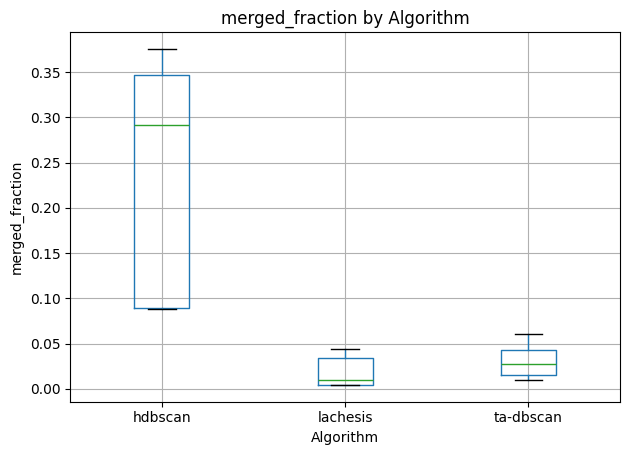

<Figure size 640x480 with 0 Axes>

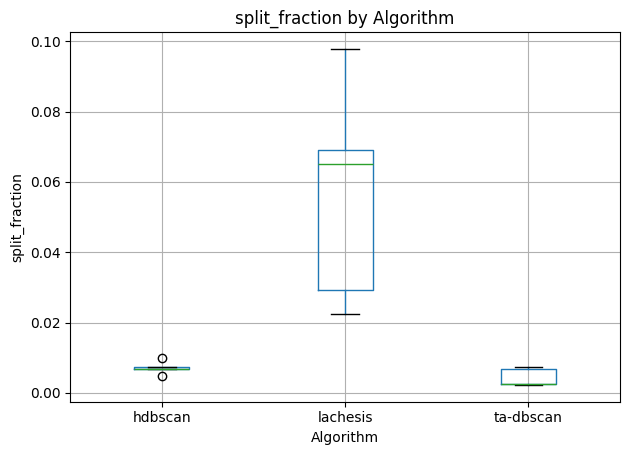

<Figure size 640x480 with 0 Axes>

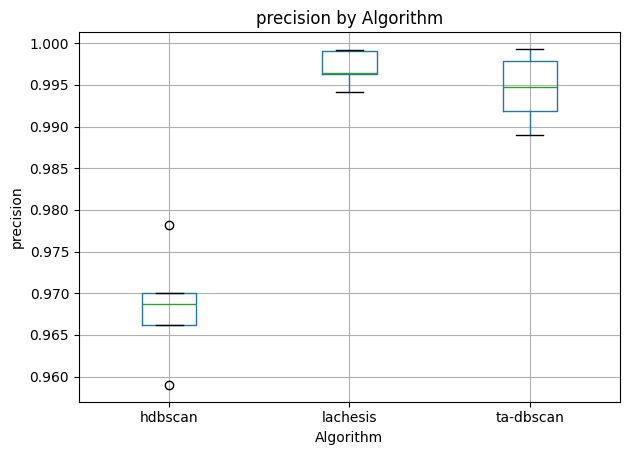

<Figure size 640x480 with 0 Axes>

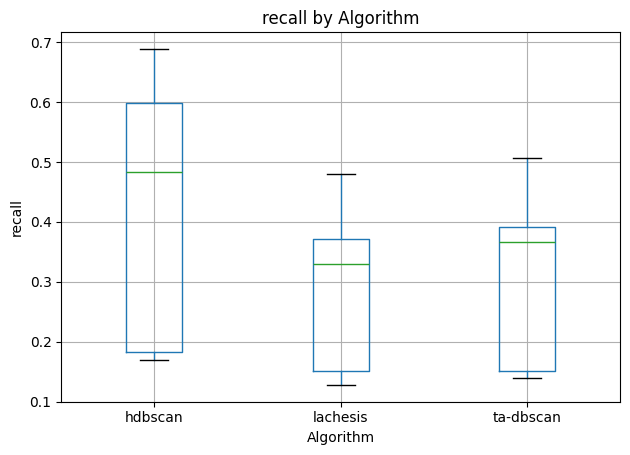

<Figure size 640x480 with 0 Axes>

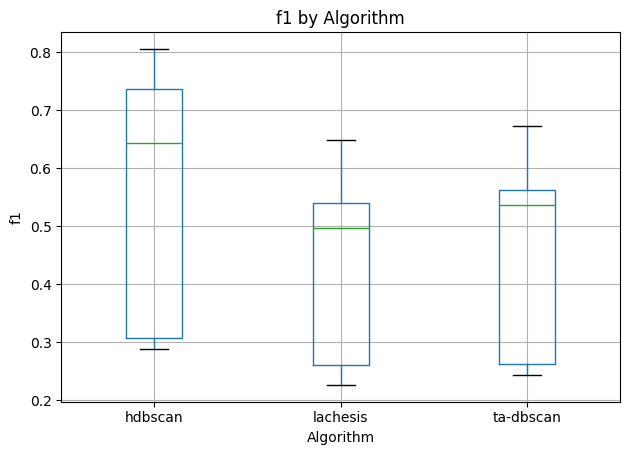

In [169]:
metrics = ["missed_fraction", "merged_fraction", "split_fraction", "precision", "recall", "f1"]

# metrics_df_no_lachesis = metrics_df.copy()
# metrics_df_no_lachesis = metrics_df_no_lachesis[metrics_df_no_lachesis['algorithm'] != 'lachesis']

for metric in metrics:
    plt.figure()
    metrics_df.boxplot(column=metric, by='algorithm')
    # metrics_df_no_lachesis.boxplot(column=metric, by='algorithm')
    plt.title(f'{metric} by Algorithm')
    plt.suptitle('')
    plt.xlabel('Algorithm')
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()

plt.show()

In [164]:
import nomad.city_gen as cg
city = cg.load('../garden-city.pkl')

def classify_building(building):
    n_blocks = len(building.blocks)
    if n_blocks == 1:
        return 'small'
    elif 2 <= n_blocks <= 3:
        return 'medium'
    else:
        return 'big'

building_sizes = {
    b_id: classify_building(b_obj)
    for b_id, b_obj in city.buildings.items()
}

building_sizes

def clasify_dwell(stop_table):
    # (low, mid, high)
    return

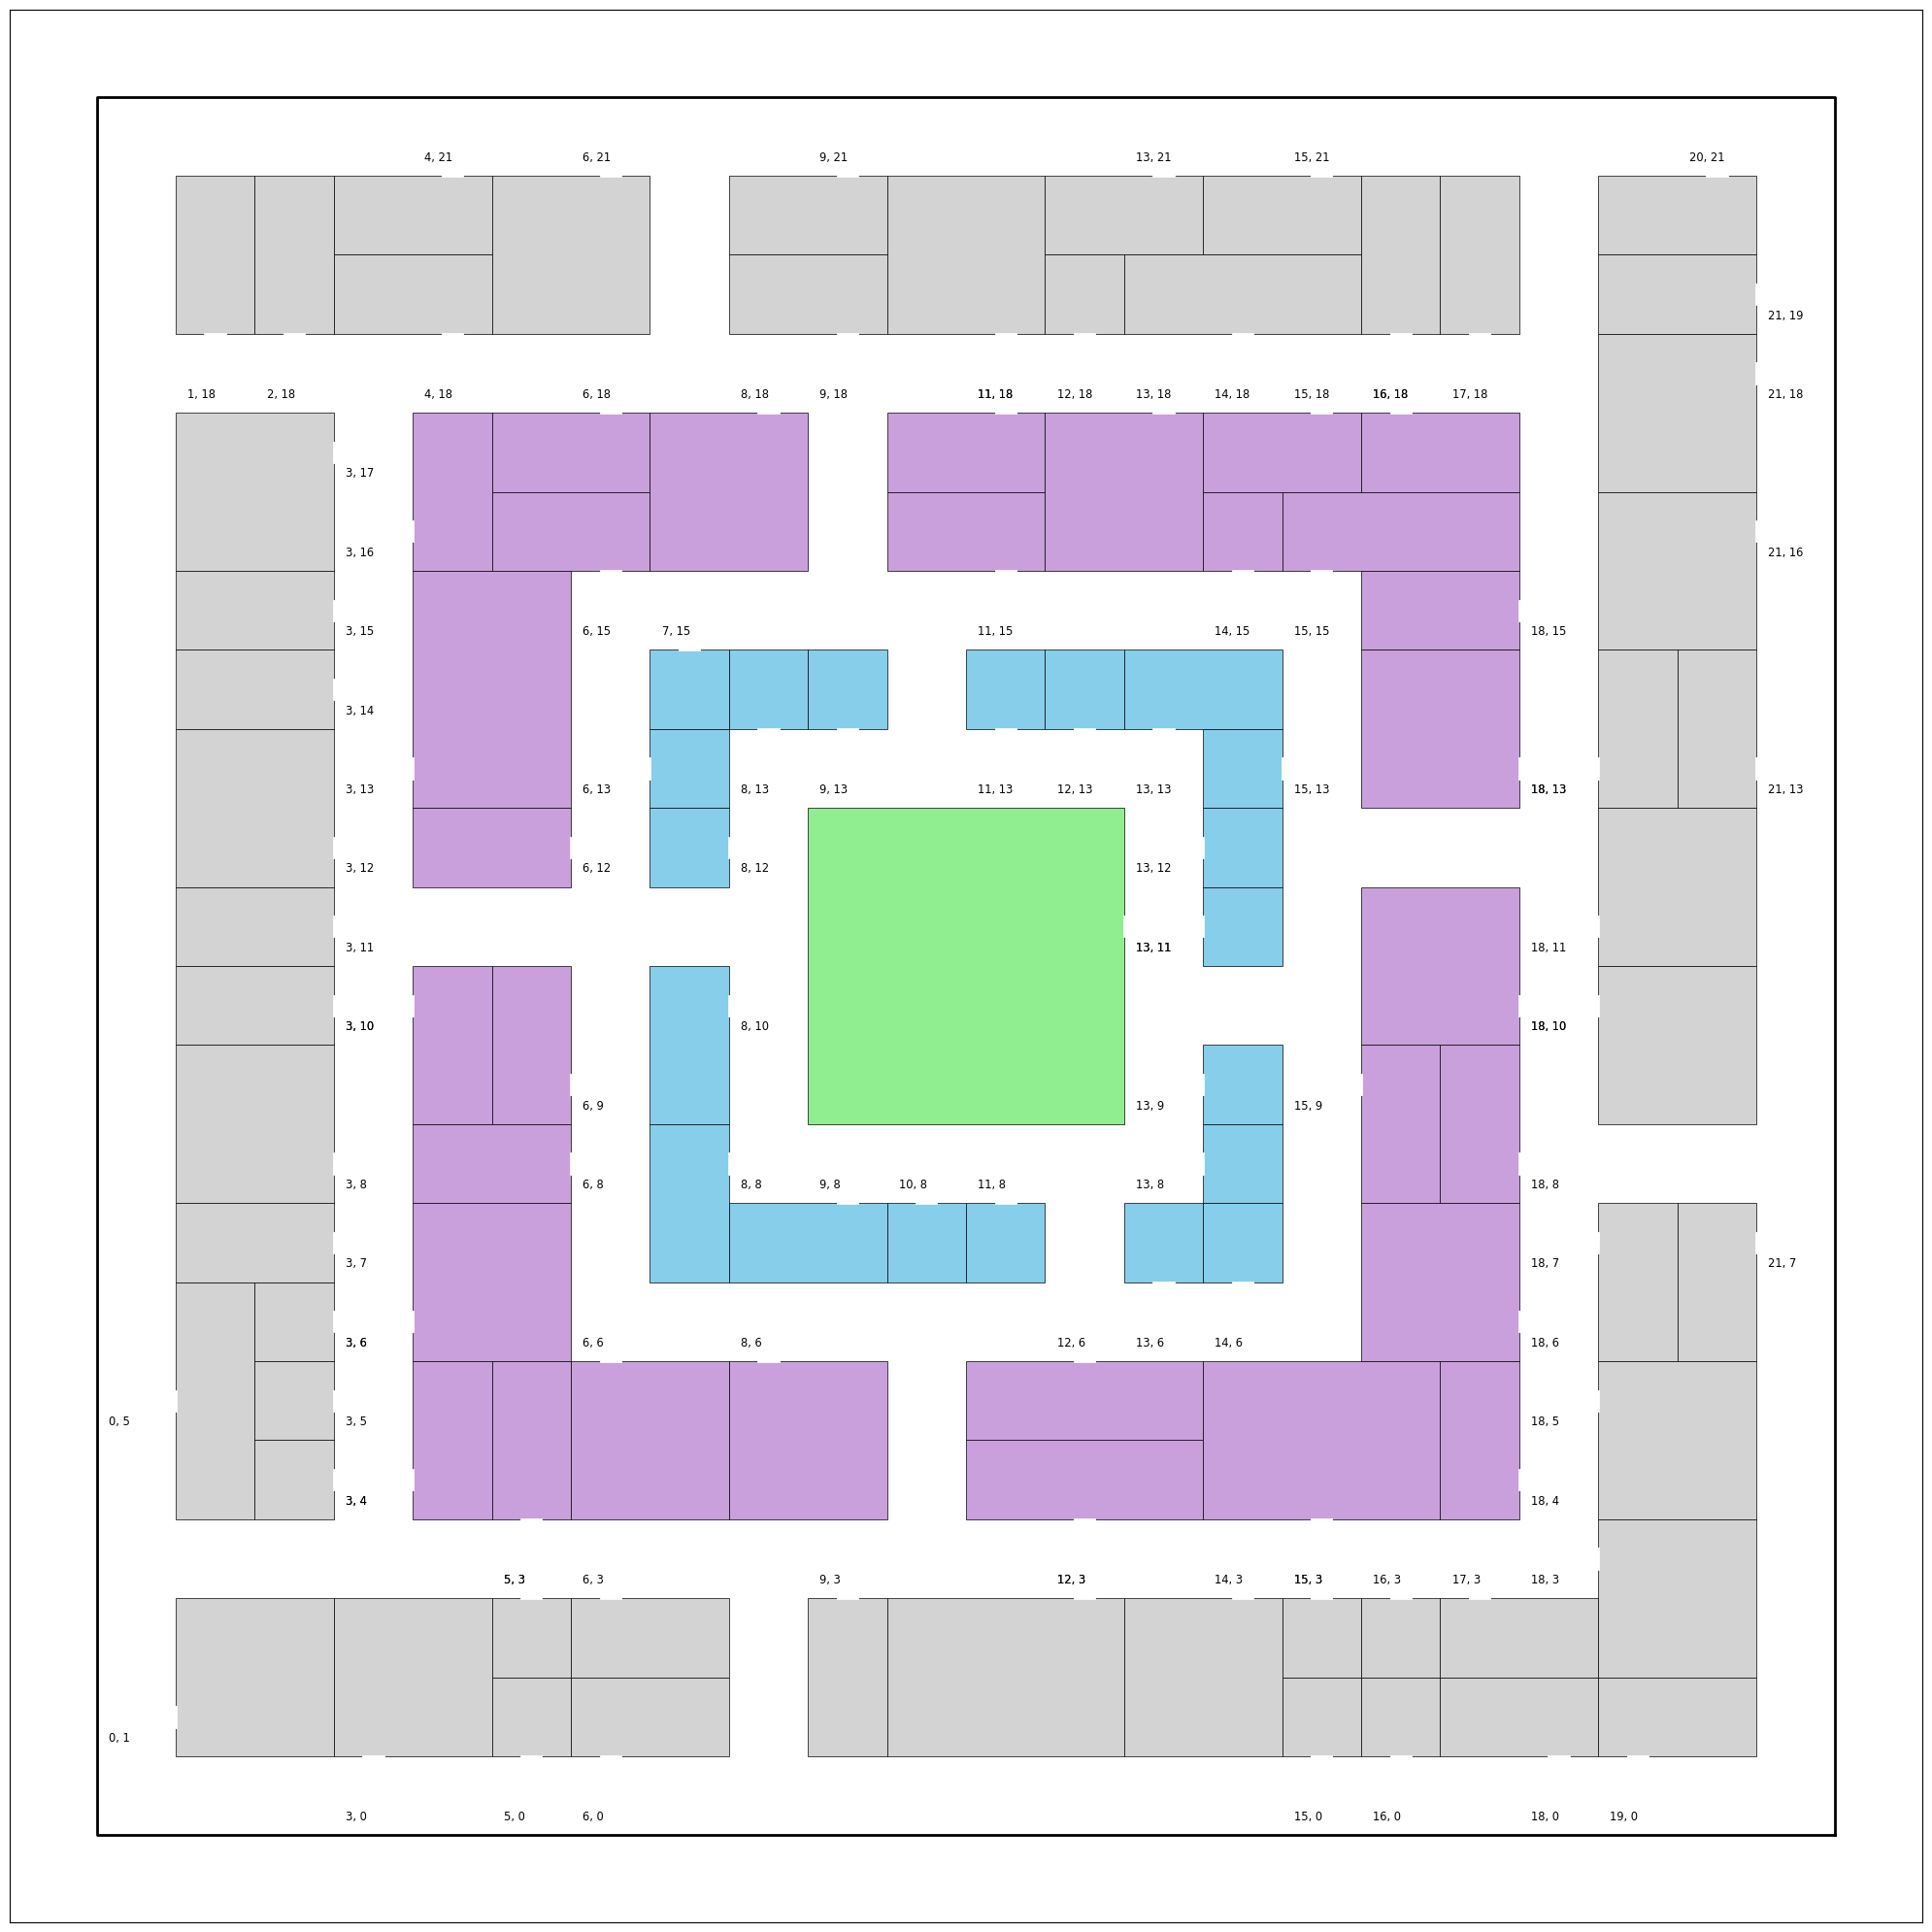

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.box(on=True)

# Plotting Garden City Map

city.plot_city(ax, doors=True, address=True)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [88]:
city.buildings['r-x5-y0'].blocks

[(5, 1)]

In [78]:
city.buildings

{'p-x13-y11': <nomad.city_gen.Building at 0x13ba8ea10>,
 'h-x8-y8': <nomad.city_gen.Building at 0x13ba8de70>,
 'h-x9-y8': <nomad.city_gen.Building at 0x14e4a7970>,
 'h-x10-y8': <nomad.city_gen.Building at 0x14e4a7460>,
 'h-x11-y8': <nomad.city_gen.Building at 0x14e4a6710>,
 'h-x13-y6': <nomad.city_gen.Building at 0x14e4a7fa0>,
 'h-x14-y6': <nomad.city_gen.Building at 0x14e4a7df0>,
 'h-x13-y8': <nomad.city_gen.Building at 0x14e4a6e60>,
 'h-x13-y9': <nomad.city_gen.Building at 0x14e4a7760>,
 'h-x13-y11': <nomad.city_gen.Building at 0x14e4a7d90>,
 'h-x13-y12': <nomad.city_gen.Building at 0x14e4a63b0>,
 'h-x15-y13': <nomad.city_gen.Building at 0x14e4a75e0>,
 'h-x13-y13': <nomad.city_gen.Building at 0x14e4a4910>,
 'h-x12-y13': <nomad.city_gen.Building at 0x14e4a6320>,
 'h-x11-y13': <nomad.city_gen.Building at 0x14e4a7f40>,
 'h-x9-y13': <nomad.city_gen.Building at 0x14e4a6110>,
 'h-x8-y13': <nomad.city_gen.Building at 0x14e4a61d0>,
 'h-x7-y15': <nomad.city_gen.Building at 0x14e4a42b0>,
 'h-x